In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_images = pd.read_csv('DS 4002/Project 3/annotations/list.txt', delim_whitespace=True, comment="#", header=None, 
                        names=["filename", "class_id", "species", "breed_id"])
df_images.head()

/var/folders/v8/8n5_rthx5t7b6swk1_h0lb6h0000gn/T/ipykernel_38868/582611708.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_images = pd.read_csv('DS 4002/Project 3/annotations/list.txt', delim_whitespace=True, comment="#", header=None,


,filename,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [6]:
from PIL import Image
import os

def load_image(base_filename, img_dir="images"): 
    img_path = os.path.join(img_dir, f"{base_filename}.jpg") 
    try:
        with Image.open(img_path) as img:
            return img.copy()
    except Exception as e:
        print(f"Error opening {img_path}: {e}")
        return None

df_images['image'] = df_images['filename'].apply(lambda x: load_image(x, img_dir='DS 4002/Project 3/images'))


In [12]:
df_images.head()

,filename,class_id,species,breed_id,image
0,Abyssinian_100,1,1,1,<PIL.Image.Image image mode=RGB size=394x500 a...
1,Abyssinian_101,1,1,1,<PIL.Image.Image image mode=RGB size=450x313 a...
2,Abyssinian_102,1,1,1,<PIL.Image.Image image mode=RGB size=500x465 a...
3,Abyssinian_103,1,1,1,<PIL.Image.Image image mode=RGB size=500x351 a...
4,Abyssinian_104,1,1,1,<PIL.Image.Image image mode=RGB size=600x363 a...


### Begin building classification model

In [35]:
!pip install tensorflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 18.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 19.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 12.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.6/342.6 kB 15.6 MB/s eta 0:00:00


In [38]:
# Resize images to 128x128, save in X array
target_size = (128, 128)
def process_image(img, target_size):
    img = img.convert("RGB")
    img = img.resize(target_size)
    arr = np.array(img).astype("float32") / 255.0
    return arr

X = np.array([process_image(img, target_size) for img in df_images['image']])

In [58]:
# Save images classes as y, subtracting 1 for zero-indexing
y = df_images['class_id'].astype(int) - 1

In [60]:
# One hot encoding class ids 
num_classes = len(np.unique(y))
y_categorical = keras.utils.to_categorical(y, num_classes=num_classes)

In [62]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42
)

In [68]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

In [70]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [72]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.0321 - loss: 3.9180 - val_accuracy: 0.0340 - val_loss: 3.5998
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.0494 - loss: 3.5763 - val_accuracy: 0.0519 - val_loss: 3.4926
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.1329 - loss: 3.2787 - val_accuracy: 0.0901 - val_loss: 3.3858
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.2588 - loss: 2.7379 - val_accuracy: 0.0867 - val_loss: 3.4043
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.4258 - loss: 2.0947 - val_accuracy: 0.0867 - val_loss: 3.7246
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.5917 - loss: 1.4570 - val_accuracy: 0.0893 - val_loss: 4.0952
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.7155 - loss: 1.0127 - val_accuracy: 0.0893 - val_loss: 4.3614
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.7992 - loss: 0

In [74]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1086 - loss: 5.4924
Test accuracy: 0.11632653325796127


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


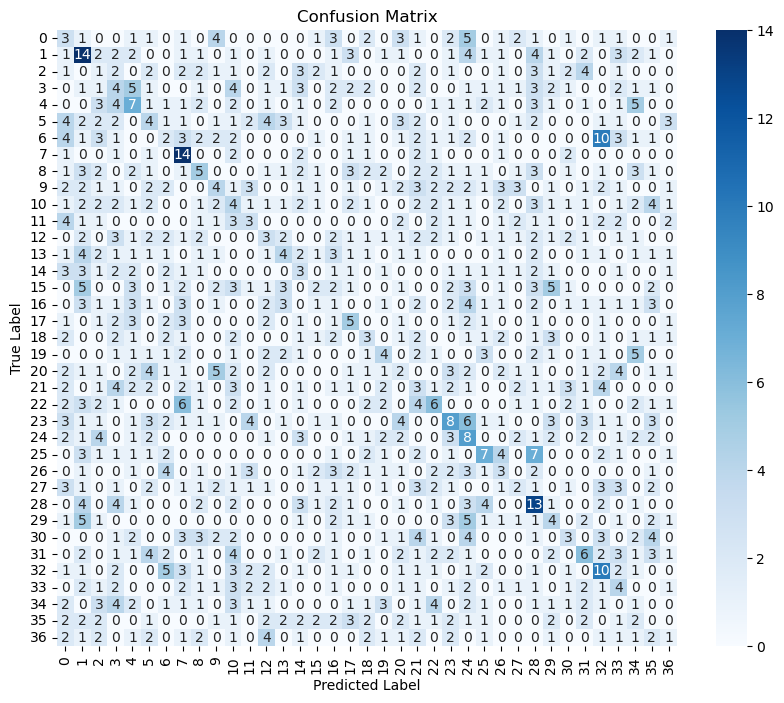

In [76]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()